In [12]:
import seaborn as sns
import requests
import zipfile
import io
import polars as pl
from matplotlib import pyplot as plt
from datetime import datetime

In [13]:
data_url = "https://foerderdatenbankdump.fra1.cdn.digitaloceanspaces.com/data/data.zip"

In [14]:
response = requests.get(data_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df = pl.read_parquet(f)

print(f"{len(df)} Förderprogramme")
print(df.columns)
print(df.dtypes)

2501 Förderprogramme
['id_hash', 'id_url', 'url', 'title', 'description', 'more_info', 'legal_basis', 'contact_info_institution', 'contact_info_street', 'contact_info_city', 'contact_info_fax', 'contact_info_phone', 'contact_info_email', 'contact_info_website', 'funding_type', 'funding_area', 'funding_location', 'eligible_applicants', 'funding_body', 'further_links', 'checksum', 'license_info', 'previous_update_dates', 'last_updated', 'deleted']
[String, String, String, String, String, String, String, String, String, String, String, String, String, String, List(String), List(String), List(String), List(String), String, List(String), String, String, List(Datetime(time_unit='us', time_zone=None)), Datetime(time_unit='us', time_zone=None), Boolean]


In [23]:
current_date = datetime.today()
most_recent_updated = df["last_updated"].max()

print("today is ", current_date)
print("most recent update (updates when crawler ran):", most_recent_updated)

today is  2025-04-23 13:44:31.981798
most recent update (updates when crawler ran): 2025-04-23 02:00:13.768435


In [16]:
current_df = df.filter(pl.col("deleted") == False)

## Descriptive Statistics

### Funding Area

Multiple areas are possible per program

<Axes: xlabel='count'>

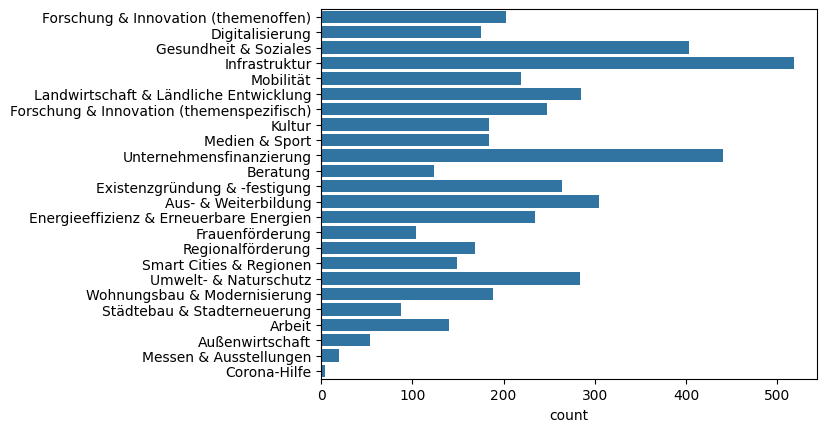

In [17]:
fg_lst = [x for xs in current_df["funding_area"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Funding Location

Multiple applicant locations are possible per program.

<Axes: xlabel='count'>

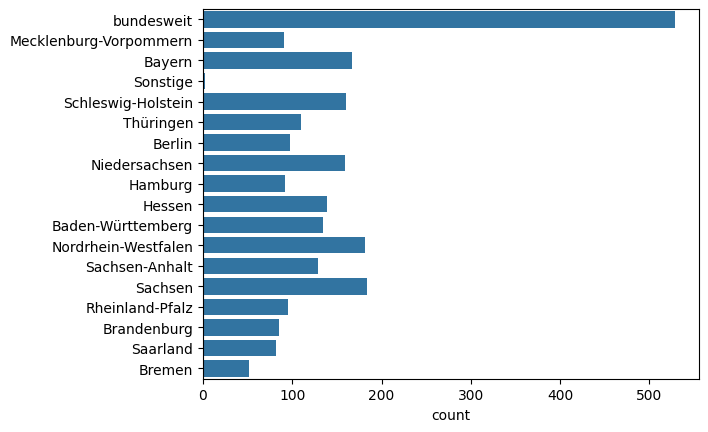

In [18]:
fg_lst = [x for xs in df["funding_location"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Eligible Applicant Types

Multiple applicant types are possible per program

<Axes: xlabel='count'>

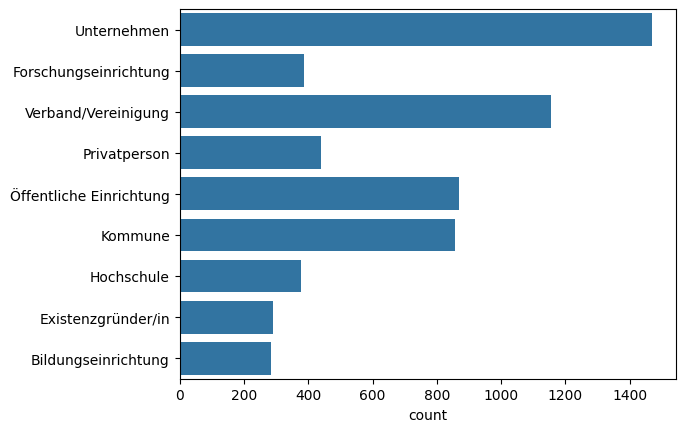

In [19]:
fg_lst = [x for xs in df["eligible_applicants"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Funding Types
Multiple funding types are possible

<Axes: xlabel='count'>

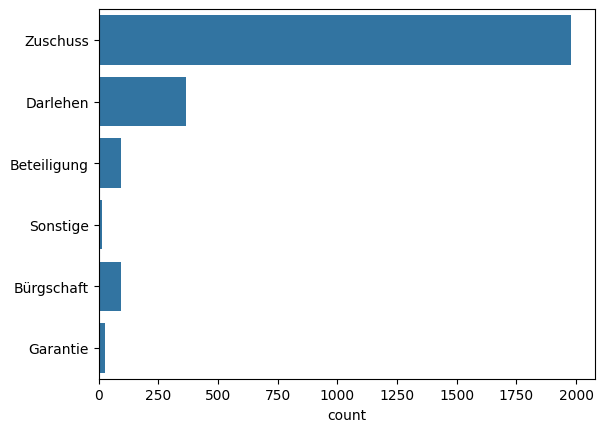

In [20]:
fg_lst = [x for xs in current_df["funding_type"] if xs is not None for x in xs]
sns.countplot(fg_lst)

## Metadata

### Added Programs

/tmp/ipykernel_4171/2054477162.py:19: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


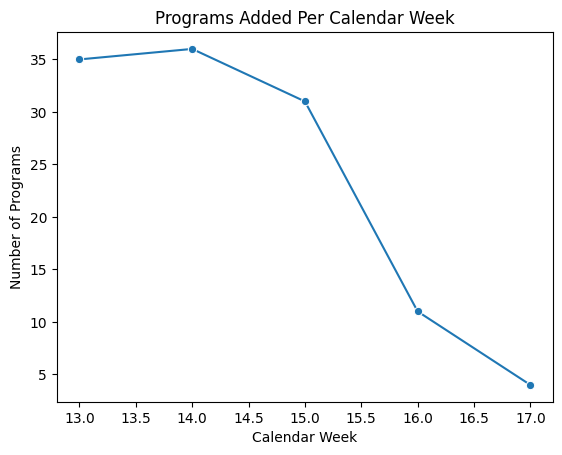

In [21]:

if len(df.filter(df["last_updated"].is_null())) > 0:
    df = df.with_columns(
        pl.when(pl.col("previous_update_dates").is_not_null())
        .then(pl.col("previous_update_dates").list.first())
        .otherwise(pl.col("last_updated"))
        .alias("creation_date")
    )

    df = df.with_columns(
        pl.col("creation_date").dt.week().alias("week")
    )

    # filtering first recorded week, because then programs were added initially
    first_week = df.select(pl.col("week").min()).to_numpy()[0][0]
    df_filtered = df.filter(pl.col("week") != first_week)

    weekly_counts = (
        df_filtered.group_by("week")
        .count()
        .rename({"count": "program_count"})  
        .sort("week")
    )

    sns.lineplot(data=weekly_counts, x="week", y="program_count", marker="o")
    plt.title("Programs Added Per Calendar Week")
    plt.xlabel("Calendar Week")
    plt.ylabel("Number of Programs")
    plt.show()
else:
    print("No update history available yet")

### Deleted Programs

In [27]:
df.filter(pl.col("deleted") == True)

id_hash,id_url,url,title,description,more_info,legal_basis,contact_info_institution,contact_info_street,contact_info_city,contact_info_fax,contact_info_phone,contact_info_email,contact_info_website,funding_type,funding_area,funding_location,eligible_applicants,funding_body,further_links,checksum,license_info,previous_update_dates,last_updated,deleted,creation_date,week
str,str,str,str,str,str,str,str,str,str,str,str,str,str,list[str],list[str],list[str],list[str],str,list[str],str,str,list[datetime[μs]],datetime[μs],bool,datetime[μs],i8
"""cd239bf6a84757d5539407ce987e63…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"[2025-03-21 02:00:15.240942, 2025-03-29 02:00:15.050196]",null,true,2025-03-21 02:00:15.240942,12
"""603ff2fb768a37bd0c8a65e5d87663…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-04-09 02:00:17.145406],null,true,2025-04-09 02:00:17.145406,15
"""41dc3496cb5151d9eb8a045c221f85…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-03-21 02:00:15.240942],null,true,2025-03-21 02:00:15.240942,12
"""76f566adbb1c2c7136db051d1383bb…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-04-05 02:00:16.625996],null,true,2025-04-05 02:00:16.625996,14
"""5a05ff438173166e880811afec835e…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-04-03 02:00:15.801169],null,true,2025-04-03 02:00:15.801169,14
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""08aaf1b5392742541c4a1abd928397…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-04-01 02:00:07.822446],null,true,2025-04-01 02:00:07.822446,14
"""4d08fa4d67141112e236be322dbbdf…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[2025-03-27 02:00:20.865257],null,true,2025-03-27 02:00:20.865257,13
"""3c493c1585624f8435e3656584ebe8…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"[2025-03-27 02:00:20.865257, 2025-04-11 02:00:16.589782]",null,true,2025-03-27 02:00:20.865257,13
